This notebook explains PyHEADTAIL's ideal transverse feedback implementation.

Dec 2018, Adrian Oeftiger

# general imports

In [1]:
from __future__ import division, print_function

import numpy as np
np.random.seed(42)

from scipy.constants import m_p, c, e

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# sets the PyHEADTAIL directory etc.
try:
    from settings import *
except:
    pass

# PyHEADTAIL imports

In [3]:
from PyHEADTAIL.particles import generators
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.trackers.longitudinal_tracking import LinearMap

PyHEADTAIL v1.12.4.15




# PySussix imports

Sussix is a tune analysis tool: https://cds.cern.ch/record/702438/files/sl-note-98-017.pdf .
If you do not have PySussix, its python interface, find it under https://github.com/PyCOMPLETE/PySussix .

In [4]:
try:
    from PySussix import Sussix
except ImportError:
    print ('ERROR: This interactive test needs the PySussix module. Trying PySUSSIX')
    from PySUSSIX import Sussix
    print('PySUSSIX found')

# Setting up the machine and functions

In [5]:
# Basic parameters.
n_turns = 500
n_macroparticles = 1000

Q_x = 64.28
Q_y = 59.31
Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_x = 0.
alpha_y = 0.
beta_x = 66.0064
beta_y = 71.5376
alpha_0 = [0.0003225]

# HELPERS
def gimme():
    ones = np.ones(2, dtype=float)
    trans_map = TransverseMap(
        [0, C], 
        0 * ones, beta_x * ones, 0 * ones, 
        0 * ones, beta_y * ones, 0 * ones, 
        Q_x, Q_y)
    long_map = LinearMap(alpha_0, C, Q_s)
    bunch = generate_bunch(
        n_macroparticles, alpha_x, alpha_y, beta_x, beta_y,
        long_map)
    return bunch, trans_map, long_map

def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, linear_map):
    intensity = 1.0e11
    sigma_z = 0.06
    gamma = 3730.26
    gamma_t = 1. / np.sqrt(alpha_0)
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = (linear_map.eta(dp=0, gamma=gamma) * linear_map.circumference / 
              (2 * np.pi * linear_map.Q_s))

    epsn_x = 3e-6 # [m rad]
    epsn_y = 3e-6 # [m rad]
    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e) 

    bunch = generators.generate_Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma=gamma, mass=m_p, circumference=C,
        alpha_x=alpha_x, beta_x=beta_x, epsn_x=epsn_x,
        alpha_y=alpha_y, beta_y=beta_y, epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z)
    
    return bunch

def calc_sussix_spec(x, xp, y, yp, q_x, q_y, n_lines=1):
    # Initialise Sussix object
    SX = Sussix()
    SX.sussix_inp(nt1=1, nt2=len(x), idam=2, ir=0, tunex=q_x, tuney=q_y)

    tunes_x = np.empty(n_lines)
    tunes_y = np.empty(n_lines)

    SX.sussix(x, xp,
              y, yp,
              # this line is not used by sussix:
              x, xp)

    os.remove('sussix.inp')

    return SX.ox[:n_lines], SX.oy[:n_lines]

# Let's go

Creating resistive transverse damper:

In [6]:
damping_rate = 50 # in turns

# create transverse feedback instance
damper = TransverseDamper(damping_rate, damping_rate)

# create bunch
bunch, trans_map, long_map = gimme()

# simulate initial kick by offset of 100um
bunch.xp -= bunch.mean_xp()
bunch.yp -= bunch.mean_yp()
bunch.x -= bunch.mean_x() - 1e-4
bunch.y -= bunch.mean_y() - 1e-4

# assemble one turn map
one_turn_map = list(trans_map) + [long_map, damper]

Dampers active


We track for a number of turns to evaluate the damping of the kicked bunch:

In [7]:
# prepare empty arrays to record transverse moments
x = np.empty(n_turns, dtype=float)
xp = np.empty_like(x)
y = np.empty_like(x)
yp = np.empty_like(x)

# actual tracking
t = np.arange(n_turns)
for i in t:
    for m in one_turn_map:
        m.track(bunch)
        x[i] = bunch.mean_x()
        xp[i] = bunch.mean_xp()
        y[i] = bunch.mean_y()
        yp[i] = bunch.mean_yp()

Let's evaluate the damping time:

In [8]:
# evaluation of dipolar bunch moments
j_x = np.sqrt(x**2 + (beta_x * xp)**2)
exponent_x, amplitude_x = np.polyfit(t, np.log(2 * j_x), 1)

j_y = np.sqrt(y**2 + (beta_y * yp)**2)
exponent_y, amplitude_y = np.polyfit(t, np.log(2 * j_y), 1)

print ('Horizontal reconstructed damping time: {:.3f} turns'.format(1/exponent_x))
print ('Vertical reconstructed damping time: {:.3f} turns'.format(1/exponent_y))

Horizontal reconstructed damping time: -48.994 turns
Vertical reconstructed damping time: -48.994 turns


Indeed, the reconstructed damping times fit the initial setting of the transverse resistive damper. The centroid motion and the fit look as follows:

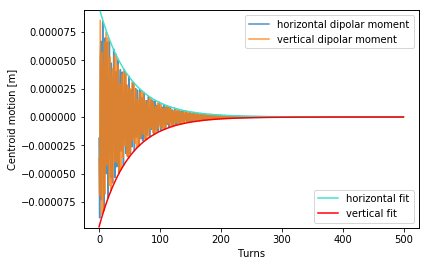

In [9]:
plt.plot(t, x, label='horizontal dipolar moment', alpha=0.8)
plt.plot(t, y, label='vertical dipolar moment', alpha=0.8)
ylim = plt.ylim()
plt.legend(loc=0);
plt.xlabel('Turns')
plt.ylabel('Centroid motion [m]')
plt.twinx()
plt.plot(t, np.exp(amplitude_x + (exponent_x*t)) / 2., color='turquoise', label='horizontal fit')
plt.plot(t, -np.exp(amplitude_x + (exponent_x*t)) / 2., color='red', label='vertical fit')
plt.ylim(ylim)
plt.legend(loc=4)
plt.yticks([]);

A purely resistive damper (standard setting of the `TransverseDamper`) has zero reactance part and should therefore not affect the tune of the beam. Let's confirm this by frequency analysis using `PySussix`. We investigate the fractional tune:

In [10]:
spec_x, spec_y = calc_sussix_spec(x, xp, y, yp, Q_x%1, Q_y%1)
print ('Horizontal fractional tune: {:.3f} vs. reconstructed {:.3f}'.format(Q_x%1, spec_x[0]))
print ('Vertical fractional tune: {:.3f} vs. reconstructed {:.3f}'.format(Q_y%1, spec_y[0]))

Horizontal fractional tune: 0.280 vs. reconstructed 0.280
Vertical fractional tune: 0.310 vs. reconstructed 0.310


$\implies$ nice, indeed we have no tune shift for the default resistive damper.

## Damper Phase Scan

Let's scan the phase of the damper in order to vary the resistive and reactive components of the feedback system:

In [11]:
damping_rate_x = 50 # in turns
damping_rate_y = 25 # in turns
phases = np.arange(0, 360, 30) # in degrees

tune_shifts_x = np.empty(len(phases), dtype=np.complex128)
tune_shifts_y = np.empty_like(tune_shifts_x)

for k, phase in enumerate(phases):
    # create transverse feedback instances
    # (separately because of different beta functions,
    # which are needed now for the reactive component)
    damper_x = TransverseDamper.horizontal(
        damping_rate_x, phase=phase, local_beta_function=beta_x)
    damper_y = TransverseDamper.vertical(
        damping_rate_y, phase=phase, local_beta_function=beta_y)

    # create bunch
    bunch, trans_map, long_map = gimme()
    
    # simulate initial kick by offset of 100um
    bunch.xp -= bunch.mean_xp()
    bunch.yp -= bunch.mean_yp()
    bunch.x -= bunch.mean_x() - 1e-4
    bunch.y -= bunch.mean_y() - 1e-4
    
    # assemble one turn map
    one_turn_map = list(trans_map) + [long_map, damper_x, damper_y]
    
    # prepare empty arrays to record transverse moments
    x = np.empty(n_turns, dtype=float)
    xp = np.empty_like(x)
    y = np.empty_like(x)
    yp = np.empty_like(x)
    
    # actual tracking
    t = range(n_turns)
    for i in t:
        for m in one_turn_map:
            m.track(bunch)
            x[i] = bunch.mean_x()
            xp[i] = bunch.mean_xp()
            y[i] = bunch.mean_y()
            yp[i] = bunch.mean_yp()
    
    # evaluation of rise time / imaginary tune shift
    j_x = np.sqrt(x**2 + (beta_x * xp)**2)
    exponent_x, amplitude = np.polyfit(t, np.log(2 * j_x), 1)
    im_x = exponent_x / (2*np.pi)
    
    j_y = np.sqrt(y**2 + (beta_y * yp)**2)
    exponent_y, amplitude = np.polyfit(t, np.log(2 * j_y), 1)
    im_y = exponent_y / (2*np.pi)
    
    # evaluation of real tune shift
    spec_x, spec_y = calc_sussix_spec(x, xp, y, yp, Q_x%1, Q_y%1)
    re_x, re_y = Q_x%1 - spec_x[0], Q_y%1 - spec_y[0]
    
    # storing complex tune shifts for current phase
    tune_shifts_x[k] = re_x + 1j*im_x
    tune_shifts_y[k] = re_y + 1j*im_y

Damper in horizontal plane active
Damper in vertical plane active
Damper in horizontal plane active
Damper in vertical plane active
Damper in horizontal plane active
Damper in vertical plane active
Damper in horizontal plane active
Damper in vertical plane active
Damper in horizontal plane active
Damper in vertical plane active
Damper in horizontal plane active
Damper in vertical plane active
Damper in horizontal plane active
Damper in vertical plane active
Damper in horizontal plane active
Damper in vertical plane active
Damper in horizontal plane active
Damper in vertical plane active
Damper in horizontal plane active
Damper in vertical plane active
Damper in horizontal plane active
Damper in vertical plane active
Damper in horizontal plane active
Damper in vertical plane active


Indeed, the complex tune shift moves on a circle in the complex tune plane: the imaginary part corresponds to the damping/growth rate inflicted on the beam centroid (resistive action of the feedback), while the real part indicates the frequency shift of the centroid motion (reactive action of the feedback). The radius of the circle depends on the damping rate while the complex angle corresponds to the feedback phase:

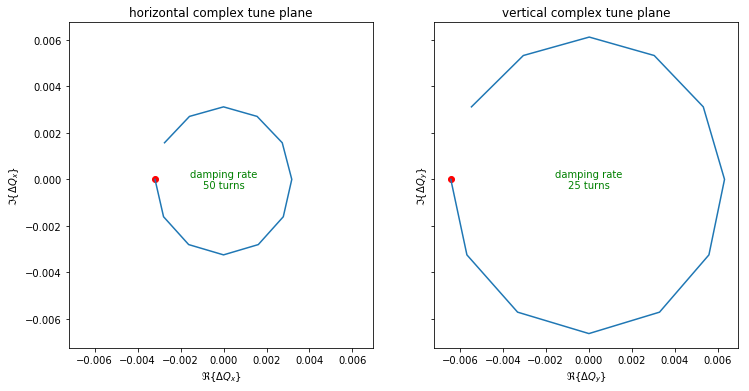

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

plt.sca(ax[0])
plt.title('horizontal complex tune plane')
plt.plot(tune_shifts_x.real, tune_shifts_x.imag)
plt.scatter(tune_shifts_x.real[0], tune_shifts_x.imag[0], color='red')
plt.xlabel(r'$\Re\{\Delta Q_x\}$')
plt.ylabel(r'$\Im\{\Delta Q_x\}$')
plt.text(0, 0, 'damping rate\n{} turns'.format(damping_rate_x), color='green', 
         horizontalalignment='center', verticalalignment='center')

plt.sca(ax[1])
plt.title('vertical complex tune plane')
plt.plot(tune_shifts_y.real, tune_shifts_y.imag)
plt.scatter(tune_shifts_y.real[0], tune_shifts_y.imag[0], color='red')
plt.xlabel(r'$\Re\{\Delta Q_y\}$')
plt.ylabel(r'$\Im\{\Delta Q_y\}$')
plt.text(0, 0, 'damping rate\n{} turns'.format(damping_rate_y), color='green', 
         horizontalalignment='center', verticalalignment='center');

Looking at the real and imaginary parts of the complex tune shift separately for both planes demonstrates the contribution of resistive and reactive feedback component:

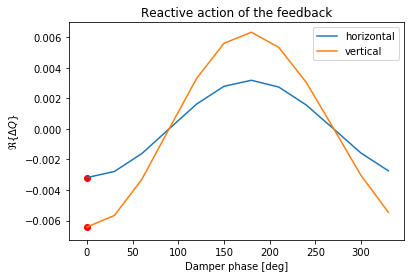

In [13]:
plt.plot(phases, tune_shifts_x.real, label='horizontal')
plt.scatter(phases[0], tune_shifts_x.real[0], color='red')
plt.plot(phases, tune_shifts_y.real, label='vertical')
plt.scatter(phases[0], tune_shifts_y.real[0], color='red')
plt.legend()
plt.title('Reactive action of the feedback')
plt.xlabel('Damper phase [deg]')
plt.ylabel(r'$\Re\{\Delta Q\}$');

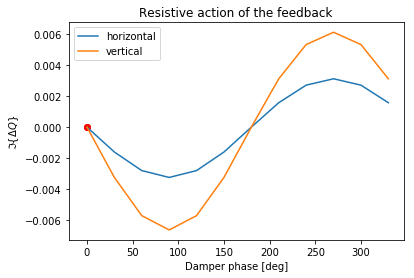

In [14]:
plt.plot(phases, tune_shifts_x.imag, label='horizontal')
plt.scatter(phases[0], tune_shifts_x.imag[0], color='red')
plt.plot(phases, tune_shifts_y.imag, label='vertical')
plt.scatter(phases[0], tune_shifts_y.imag[0], color='red')
plt.legend()
plt.title('Resistive action of the feedback')
plt.xlabel('Damper phase [deg]')
plt.ylabel(r'$\Im\{\Delta Q\}$');

The `TransverseDamper` class implements an ideal in-place transverse feedback -- for a more realistic feedback implementation (much closer to the LHC ADT for example) please have a look at the `feature/multibunch_feedback` branch of PyHEADTAIL at https://github.com/PyCOMPLETE/PyHEADTAIL/tree/feature/multibunch_feedback (which will hopefully be merged into develop over the course of the next months).